In [6]:
import numpy as np
import scipy as sp
import matplotlib as mpl
import pandas as pd
import csv
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy import integrate
from lmfit import minimize, Parameters, Parameter, report_fit
from sklearn import datasets
from sklearn.linear_model import LinearRegression
import random
#############################################################################
def meanvals(data_fileroot, size, cells):
    ''' Reads data from CSV, sorts, and renames columns'''
    fin = (data_fileroot+".csv")
    data=pd.read_csv(fin)
    data.rename(columns = {'S-Max. Principal (Abs)':'stress'}, inplace = True)
    data=data.drop(columns=['ODB Name' , 'Step' ,'Frame', 'Part Instance Name', 'Section Name', 'Material Name', 'Section Point'])
    data = data.sort_values(by=['X', 'Y','Z'], ascending=False)
    datamatrix=np.array(data)
    #############################################################################
    stressmatrix=np.empty((2016032,4))
    for n in range (1,22176352,11):
        stressmatrix[int((n-1)/11),0]=datamatrix[n,1]
        stressmatrix[int((n-1)/11),1]=datamatrix[n,2]
        stressmatrix[int((n-1)/11),2]=datamatrix[n,3]
        stressmatrix[int((n-1)/11),3]=np.average(datamatrix[n-1:n+9,4])
        
    #############################################################################
    for n in range (0,len(stressmatrix),32):
        n=n
    depthvalues=stressmatrix[n:n+32,2]
    
    #############################################################################
    lengthdivisions=np.sqrt(int(cells))
    temp=lengthdivisions-1
    bounds=np.empty((int(lengthdivisions-1),1))
    y=lengthdivisions-1
    while y>=1:
        bounds[int(y)-1]=(y/lengthdivisions)*size
        y=y-1
    #############################################################################
    binnumber=np.empty((len(stressmatrix),1))
    for n in range (0,len(stressmatrix),1):
        tempbin=np.empty((2,1))
        tempbin[0]=np.digitize(stressmatrix[n,0], bounds.flatten(),right=True)
        tempbin[1]=np.digitize(stressmatrix[n,1], bounds.flatten(),right=True)
        binnumbertemp=((tempbin[0])*(int(lengthdivisions))**0)+((tempbin[1])*(int(lengthdivisions))**1)
        binnumber[n]=int(binnumbertemp)


    stressmatrix_bins=np.append(stressmatrix,binnumber, axis=1)
    stressmatrix_bins=pd.DataFrame(stressmatrix_bins, columns=['X','Y','Z','stress','bins'])
    stressmatrix_bins=np.array(stressmatrix_bins.sort_values(by=['bins', 'Z','X','Y'], ascending=False))
    #############################################################################
    unique, counts = np.unique(stressmatrix_bins[:,4], return_counts=True)
    unique=np.flip(unique)
    counts=np.flip(counts)
    uniquedepths, countsdepths = np.unique(stressmatrix_bins[:,2], return_counts=True)
    #############################################################################
    
    runningsum=0
    binstressmatrix=np.empty((len(uniquedepths),len(unique)))
    for n in range (0,len(unique),1):
        temp_bins=np.empty((counts[n],1))
        temp_depths=np.empty((counts[n],1))
        #temp_bins=np.array([stressmatrix_bins.Z[runningsum-counts[n]:runningsum],stressmatrix_bins.stress[runningsum-counts[n]:runningsum]])
        temp_bins=stressmatrix_bins[runningsum:runningsum+counts[n]-1,3]
        temp_depths=stressmatrix_bins[runningsum:runningsum+counts[n]-1,2]
        uniquedepths, countsdepths = np.unique(temp_depths, return_counts=True)
        runningsum=runningsum+counts[n]
        runningrows=0
        for p in range (0,len(uniquedepths),1):
            binstressmatrix[p,n]=np.average(temp_bins[runningrows:runningrows+countsdepths[p]-1])
            runningrows=runningrows+countsdepths[p]
            
            
    #############################################################################

    fig, ax2 = plt.subplots(1, 1)

    crossoverpts=np.empty((len(unique),1))
    totalwork=np.empty((len(unique),1))
    bestvals=np.empty((len(unique),3))
    bestvals2=np.empty((len(unique),3))

    def mod_st_exp(x,c,tau,beta):
            return (c*(np.exp(1-(((x)/tau)**(x/beta)))))

    for r in range (0,len(unique),1):
       
        init_vals =[float(binstressmatrix[0,r]), 0.2, 5]

        bounds=((-10000,0.01,-10),(0,10,10))
        
        best_vals, covar = curve_fit(mod_st_exp, -(depthvalues), (binstressmatrix[:,r]), p0=init_vals, bounds=bounds, absolute_sigma=False, maxfev=150000)
        
        bestvals[r]=best_vals


        ax2.plot(-depthvalues, binstressmatrix[:,r], label='Simulation Data %(#)03d' % \
              { "#": r+1})
        ax2.plot(-depthvalues, mod_st_exp(-depthvalues,*best_vals), label="Mod. Stretch Exp. Fit", color='orange')
        ax2.set_xlabel('Depth (mm)')
        ax2.set_ylabel('Induced Stress (MPa)')
        ax2.set_title('Modified Exponential Fit')

    ax2.grid()
    print(bestvals)
    return(bestvals, stressmatrix)

def RSD(stressmatrix, size, cells):
    ''' Reads data from CSV, sorts, and renames columns'''
    for n in range (0,len(stressmatrix),32):
        n=n
    depthvalues=stressmatrix[n:n+32,2]
    
    #############################################################################
    lengthdivisions=np.sqrt(int(cells))
    temp=lengthdivisions-1
    bounds=np.empty((int(lengthdivisions-1),1))
    y=lengthdivisions-1
    while y>=1:
        bounds[int(y)-1]=(y/lengthdivisions)*size
        y=y-1
    #############################################################################
    binnumber=np.empty((len(stressmatrix),1))
    for n in range (0,len(stressmatrix),1):
        tempbin=np.empty((2,1))
        tempbin[0]=np.digitize(stressmatrix[n,0], bounds.flatten(),right=True)
        tempbin[1]=np.digitize(stressmatrix[n,1], bounds.flatten(),right=True)
        binnumbertemp=((tempbin[0])*(int(lengthdivisions))**0)+((tempbin[1])*(int(lengthdivisions))**1)
        binnumber[n]=int(binnumbertemp)


    stressmatrix_bins=np.append(stressmatrix,binnumber, axis=1)
    stressmatrix_bins=pd.DataFrame(stressmatrix_bins, columns=['X','Y','Z','stress','bins'])
    stressmatrix_bins=np.array(stressmatrix_bins.sort_values(by=['bins', 'Z','X','Y'], ascending=False))
    #############################################################################
    unique, counts = np.unique(stressmatrix_bins[:,4], return_counts=True)
    unique=np.flip(unique)
    counts=np.flip(counts)
    uniquedepths, countsdepths = np.unique(stressmatrix_bins[:,2], return_counts=True)
    #############################################################################
    
    runningsum=0
    binstressmatrix=np.empty((len(uniquedepths),len(unique)))
    for n in range (0,len(unique),1):
        temp_bins=np.empty((counts[n],1))
        temp_depths=np.empty((counts[n],1))
        #temp_bins=np.array([stressmatrix_bins.Z[runningsum-counts[n]:runningsum],stressmatrix_bins.stress[runningsum-counts[n]:runningsum]])
        temp_bins=stressmatrix_bins[runningsum:runningsum+counts[n]-1,3]
        temp_depths=stressmatrix_bins[runningsum:runningsum+counts[n]-1,2]
        uniquedepths, countsdepths = np.unique(temp_depths, return_counts=True)
        runningsum=runningsum+counts[n]
        runningrows=0
        for p in range (0,len(uniquedepths),1):
            binstressmatrix[p,n]=np.average(temp_bins[runningrows:runningrows+countsdepths[p]-1])
            runningrows=runningrows+countsdepths[p]
            
            
    #############################################################################

    #fig, ax2 = plt.subplots(1, 1)

    crossoverpts=np.empty((len(unique),1))
    totalwork=np.empty((len(unique),1))
    bestvals=np.empty((len(unique),3))
    bestvals2=np.empty((len(unique),3))

    def mod_st_exp(x,c,tau,beta):
            return (c*(np.exp(1-(((x)/tau)**(x/beta)))))

    for r in range (0,len(unique),1):
       
        init_vals =[float(binstressmatrix[0,r]), 0.2, 5]

        bounds=((-10000,0.01,-10),(0,10,10))
        
        best_vals, covar = curve_fit(mod_st_exp, -(depthvalues), (binstressmatrix[:,r]), p0=init_vals, bounds=bounds, absolute_sigma=False, maxfev=150000)
        
        bestvals[r]=best_vals


        '''
        ax2.plot(-depthvalues, binstressmatrix[:,r], label='Simulation Data %(#)03d' % \
              { "#": r+1})
        ax2.plot(-depthvalues, mod_st_exp(-depthvalues,*best_vals), label="Mod. Stretch Exp. Fit", color='orange')
        ax2.set_xlabel('Depth (mm)')
        ax2.set_ylabel('Induced Stress (MPa)')
        ax2.set_title('Modified Exponential Fit')
        '''

    #ax2.grid()
    #print(bestvals)
    return(np.std(bestvals[:,0]),np.std(bestvals[:,1]),np.std(bestvals[:,2]))

create second function without print statements to suppress outputs \n
first command returns mean values \n
second returns RSD values \n
figure out how to get rid of calling and resorting data each iteration \n

[[-1.28884788e+03  8.91228065e-02  1.81712765e-01]]


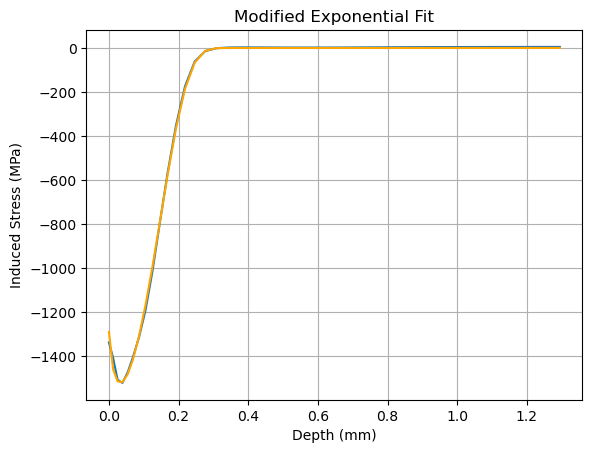

In [2]:
meanvalues, stressmatrix1=meanvals("CW32_0945_20_49100_45000_90", 5, 1)

In [3]:
stressmatrix1

array([[ 5.000000e+00,  5.000000e+00, -4.000000e-08, -1.213833e+03],
       [ 5.000000e+00,  5.000000e+00, -1.200000e-02, -1.257543e+03],
       [ 5.000000e+00,  5.000000e+00, -2.487560e-02, -1.315516e+03],
       ...,
       [ 0.000000e+00,  0.000000e+00, -1.103260e+00, -5.978680e+00],
       [ 0.000000e+00,  0.000000e+00, -1.195760e+00,  1.712900e+00],
       [ 0.000000e+00,  0.000000e+00, -1.295000e+00,  9.133310e+00]])

In [8]:
rsdvals=np.empty((25,3))
for n in range (1,25,1):
    num=RSD(stressmatrix1, 5, int(n**2))
    rsdvals[n-1,:]=num/meanvalues
    print(n)
rsdvals=np.array(rsdvals)
np.savetxt("CW32_0945_20_49100_45000_90_RSD1.csv", rsdvals, delimiter=",")

1
2
3


/var/folders/q6/xbddtjys7yl2czx_6w1s5f6m0000gn/T/ipykernel_24391/3047659187.py:174: RuntimeWarning: overflow encountered in power
  return (c*(np.exp(1-(((x)/tau)**(x/beta)))))


4
5
6


/var/folders/q6/xbddtjys7yl2czx_6w1s5f6m0000gn/T/ipykernel_24391/3047659187.py:174: RuntimeWarning: overflow encountered in power
  return (c*(np.exp(1-(((x)/tau)**(x/beta)))))


7


/var/folders/q6/xbddtjys7yl2czx_6w1s5f6m0000gn/T/ipykernel_24391/3047659187.py:174: RuntimeWarning: overflow encountered in power
  return (c*(np.exp(1-(((x)/tau)**(x/beta)))))


8


/var/folders/q6/xbddtjys7yl2czx_6w1s5f6m0000gn/T/ipykernel_24391/3047659187.py:174: RuntimeWarning: overflow encountered in power
  return (c*(np.exp(1-(((x)/tau)**(x/beta)))))


9


/var/folders/q6/xbddtjys7yl2czx_6w1s5f6m0000gn/T/ipykernel_24391/3047659187.py:174: RuntimeWarning: overflow encountered in power
  return (c*(np.exp(1-(((x)/tau)**(x/beta)))))


10


/var/folders/q6/xbddtjys7yl2czx_6w1s5f6m0000gn/T/ipykernel_24391/3047659187.py:174: RuntimeWarning: overflow encountered in power
  return (c*(np.exp(1-(((x)/tau)**(x/beta)))))


11


/var/folders/q6/xbddtjys7yl2czx_6w1s5f6m0000gn/T/ipykernel_24391/3047659187.py:174: RuntimeWarning: overflow encountered in power
  return (c*(np.exp(1-(((x)/tau)**(x/beta)))))


12


/var/folders/q6/xbddtjys7yl2czx_6w1s5f6m0000gn/T/ipykernel_24391/3047659187.py:174: RuntimeWarning: overflow encountered in power
  return (c*(np.exp(1-(((x)/tau)**(x/beta)))))


13


/var/folders/q6/xbddtjys7yl2czx_6w1s5f6m0000gn/T/ipykernel_24391/3047659187.py:174: RuntimeWarning: overflow encountered in power
  return (c*(np.exp(1-(((x)/tau)**(x/beta)))))


14


/var/folders/q6/xbddtjys7yl2czx_6w1s5f6m0000gn/T/ipykernel_24391/3047659187.py:174: RuntimeWarning: overflow encountered in power
  return (c*(np.exp(1-(((x)/tau)**(x/beta)))))


15


/var/folders/q6/xbddtjys7yl2czx_6w1s5f6m0000gn/T/ipykernel_24391/3047659187.py:174: RuntimeWarning: overflow encountered in power
  return (c*(np.exp(1-(((x)/tau)**(x/beta)))))


16


/var/folders/q6/xbddtjys7yl2czx_6w1s5f6m0000gn/T/ipykernel_24391/3047659187.py:174: RuntimeWarning: overflow encountered in power
  return (c*(np.exp(1-(((x)/tau)**(x/beta)))))


17


/var/folders/q6/xbddtjys7yl2czx_6w1s5f6m0000gn/T/ipykernel_24391/3047659187.py:174: RuntimeWarning: overflow encountered in power
  return (c*(np.exp(1-(((x)/tau)**(x/beta)))))


18


/var/folders/q6/xbddtjys7yl2czx_6w1s5f6m0000gn/T/ipykernel_24391/3047659187.py:174: RuntimeWarning: overflow encountered in power
  return (c*(np.exp(1-(((x)/tau)**(x/beta)))))


19


/var/folders/q6/xbddtjys7yl2czx_6w1s5f6m0000gn/T/ipykernel_24391/3047659187.py:174: RuntimeWarning: overflow encountered in power
  return (c*(np.exp(1-(((x)/tau)**(x/beta)))))


20


/var/folders/q6/xbddtjys7yl2czx_6w1s5f6m0000gn/T/ipykernel_24391/3047659187.py:174: RuntimeWarning: overflow encountered in power
  return (c*(np.exp(1-(((x)/tau)**(x/beta)))))


21


/var/folders/q6/xbddtjys7yl2czx_6w1s5f6m0000gn/T/ipykernel_24391/3047659187.py:174: RuntimeWarning: overflow encountered in power
  return (c*(np.exp(1-(((x)/tau)**(x/beta)))))


22


/var/folders/q6/xbddtjys7yl2czx_6w1s5f6m0000gn/T/ipykernel_24391/3047659187.py:174: RuntimeWarning: overflow encountered in power
  return (c*(np.exp(1-(((x)/tau)**(x/beta)))))


23


/var/folders/q6/xbddtjys7yl2czx_6w1s5f6m0000gn/T/ipykernel_24391/3047659187.py:174: RuntimeWarning: overflow encountered in power
  return (c*(np.exp(1-(((x)/tau)**(x/beta)))))


24
